In [1]:
import praw
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import tensorflow as tf
import os
from matplotlib import pyplot as plt

C:\Users\Kaustubh Virkar\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import cv2
import imghdr

In [3]:
NUM_POSTS = 500
nsfw_subreddit = "CrimeScene"
sfw_subreddit = ""

In [4]:
def config_reddit():
    reddit = praw.Reddit(
    client_id="RhHg9UYRJVGnc1wbqabryQ",
    client_secret="pcyFCvdeVPzDz6aWqxXqycjMsuEOgQ",
    password="sohamvadikaustubh",
    user_agent="safepost-classifier by u/nusteprojects",
    username="nusteprojects",
    )
    return reddit

In [143]:
def get_nsfw_posts(reddit ):
    images = []
    labels= []
    count = 0
    # Fetch the 10 newest posts from the Python subreddit
    subreddit = reddit.subreddit('nudes')
    for submission in subreddit.new(limit=30):
        if submission.url and submission.url.endswith(('jpg', 'jpeg', 'png')):
            print(submission.url)
            try:
                response = requests.get(submission.url)
                if response.status_code == 200:
                    img = Image.open(BytesIO(response.content))
                    img = img.resize((224,224))
                    img_array = np.array(img)
                    print(f"Shape of image: {img_array.shape}")
                    if(img_array.shape) != (224,224,3):
                        continue
                    images.append(img_array)
                    labels.append(0)
                    count += 1
                else:
                    print("failed to get the image")
            except Exception as e:
                print(f"erro : {e}")
    
    # images_tensor = tf.constant(images)
    # labels_tensor = tf.constant(labels)
    print("nsfw count  = " , count)
    return {"images" : images , "labels" : labels}


def get_sfw_posts(reddit ):
    images = []
    labels= []
    count = 0
    # Fetch the 10 newest posts from the Python subreddit
    subreddit = reddit.subreddit('happy')
    for submission in subreddit.top(limit=30):
        if submission.url and submission.url.endswith(('jpg', 'jpeg', 'png')):
            print(submission.url)
            try:
                response = requests.get(submission.url)
                if response.status_code == 200:
                    img = Image.open(BytesIO(response.content))
                    img = img.resize((224,224))
                    img_array = np.array(img)
                    print(f"Shape of image: {img_array.shape}")
                    if(img_array.shape) != (224,224,3):
                        continue
                    images.append(img_array)
                    labels.append(1)
                    count += 1
                else:
                    print("failed to get the image")
            except Exception as e:
                print(f"erro : {e}")
    
    # images_tensor = tf.constant(images)
    # labels_tensor = tf.constant(labels)
    # dataset = tf.data.Dataset.from_tensor_slices((images_tensor, labels_tensor))
    print("count sfw = " , count)
    return {"images" : images , "labels" : labels}



<h1> Data preprocessing</h1>

In [99]:
data_dir = 'data' 
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [100]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path) , "tip = " , tip)
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [165]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 1139 files belonging to 2 classes.


In [166]:
data_iterator = data.as_numpy_iterator()

In [167]:
batch = data_iterator.next()

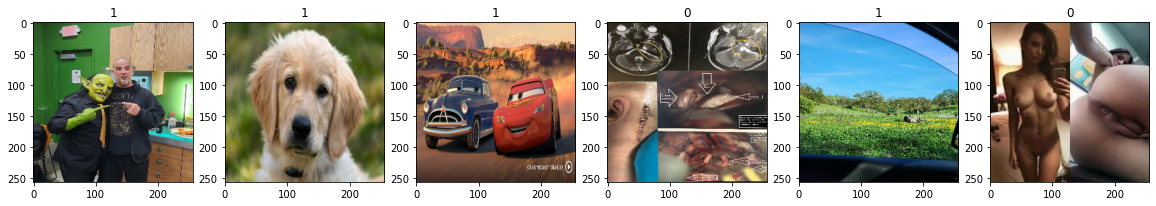

In [168]:
fig, ax = plt.subplots(ncols=6, figsize=(20,20))
for idx, img in enumerate(batch[ 0][:6]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

<h1> 1: SFW<br>0: NSFW</h1>

<h1> Data normalisation and Scaling </h1>

In [169]:
data = data.map(lambda x,y: (x/255, y))

In [170]:
train_size = int(len(data)*.8)
val_size = int(len(data)*.1)
test_size = int(len(data)*.1)

In [171]:
train_size

28

In [172]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [173]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [174]:
train_labels = []
for features, labels in train:
    train_labels.extend(labels.numpy())

# Convert to NumPy array
train_labels = np.array(train_labels)
train_labels.shape

(896,)

In [175]:
val_labels = []
for features, labels in val:
    val_labels.extend(labels.numpy())

# Convert to NumPy array
val_labels = np.array(val_labels)

<h1> CNN model </h1>

In [176]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

In [113]:
model = Sequential()

In [114]:
model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# model = Sequential([
#     Dense(256, activation='relu', input_dim=train_features_flat.shape[1]),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])

# # Compile the model
# opt = Adam(learning_rate=0.00001)
# model.compile(opt, loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\Kaustubh Virkar\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [131]:
opt = Adam(learning_rate=0.0005)
model.compile(opt, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [132]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,701,681 (14.12 MB)

 Trainable params: 3,701,681 (14.12 MB)

 Non-trainable params: 0 (0.00 B)

In [133]:
logdir='logs'

In [134]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [135]:
# tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph

<function tensorflow.python.framework.ops.reset_default_graph() -> None>

In [136]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 572ms/step - accuracy: 0.6826 - loss: 1.3893 - val_accuracy: 0.8333 - val_loss: 0.4334
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 585ms/step - accuracy: 0.8521 - loss: 0.4157 - val_accuracy: 0.8542 - val_loss: 0.4006
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 592ms/step - accuracy: 0.8590 - loss: 0.3084 - val_accuracy: 0.8750 - val_loss: 0.2904
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 586ms/step - accuracy: 0.9605 - loss: 0.1688 - val_accuracy: 0.8854 - val_loss: 0.2564
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 598ms/step - accuracy: 0.9729 - loss: 0.1323 - val_accuracy: 0.9271 - val_loss: 0.2113
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 600ms/step - accuracy: 0.9710 - loss: 0.1143 - val_accuracy: 0.9167 - val_loss: 0.2610
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 614ms/step - accuracy: 0.9617 - loss: 0.1488 - val_accuracy: 0.9167 - val_loss: 0.2007
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 614ms/step - accuracy: 0.9731 - loss: 0.0860 - val_accu

<h1> Evaluating the Model </h1>

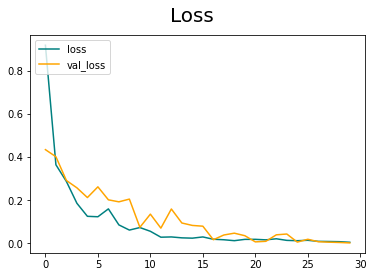

In [137]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

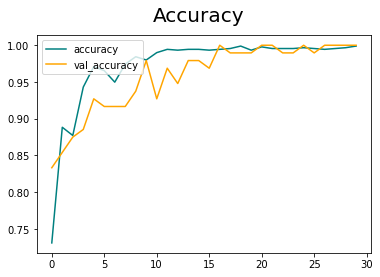

In [138]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [139]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [140]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [141]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


In [142]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.97959185, shape=(), dtype=float32) tf.Tensor(0.9895833, shape=(), dtype=float32)


<h1> Reddit pipeline </h1>

In [144]:
reddit = config_reddit()
reddit_nsfw_dataset = get_nsfw_posts(reddit)
reddit_sfw_dataset = get_sfw_posts(reddit)


https://i.redd.it/63npjdfe84uc1.jpeg
Shape of image: (224, 224, 3)
https://i.redd.it/ifqwgjg974uc1.jpeg
Shape of image: (224, 224, 3)
https://i.redd.it/ceuz9ke974uc1.jpeg
Shape of image: (224, 224, 3)
https://i.redd.it/jieqa1ln34uc1.jpeg
Shape of image: (224, 224, 3)
https://i.redd.it/yb5cjbru04uc1.jpeg
Shape of image: (224, 224, 3)
https://i.redd.it/1o9df7nn04uc1.jpeg
Shape of image: (224, 224, 3)
https://i.redd.it/wkt5rzxnz3uc1.jpeg
Shape of image: (224, 224, 3)
https://i.redd.it/v4j687qcy3uc1.jpeg
Shape of image: (224, 224, 3)
https://i.redd.it/0qd5cipum3uc1.jpeg
Shape of image: (224, 224, 3)
https://i.redd.it/5sv0apo2l3uc1.jpeg
Shape of image: (224, 224, 3)
https://i.redd.it/d0d5mwskj3uc1.jpeg
Shape of image: (224, 224, 3)
https://i.redd.it/fe50asj5j3uc1.jpeg
Shape of image: (224, 224, 3)
https://i.redd.it/e6l7vh7ai3uc1.jpeg
Shape of image: (224, 224, 3)
https://i.redd.it/nb9qewy233uc1.jpeg
Shape of image: (224, 224, 3)
https://i.redd.it/0wlygviwe3uc1.jpeg
Shape of image: (224, 224

In [145]:
for img in reddit_sfw_dataset["images"]:
    resize = tf.image.resize(img, (256,256))
    yhat = model.predict(np.expand_dims(resize/255, 0))
    if yhat > 0.5: 
        print(f'Predicted class is sfw')
    else:
        print(f'Predicted class is nsfw')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicted class is nsfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted class is sfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted class is sfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted class is nsfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted class is nsfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted class is sfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted class is sfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted class is nsfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class is nsfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted class is sfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted class is nsfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted class is nsfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted class is nsfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted class is sfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted class is nsfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted class is nsfw
1/1 ━━━━━━━━━━

In [146]:
for img in reddit_nsfw_dataset["images"]:
    resize = tf.image.resize(img, (256,256))
    yhat = model.predict(np.expand_dims(resize/255, 0))
    if yhat > 0.5: 
        print(f'Predicted class is sfw')
    else:
        print(f'Predicted class is nsfw')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted class is sfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted class is sfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted class is nsfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted class is nsfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted class is nsfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted class is nsfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted class is sfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted class is nsfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted class is nsfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted class is nsfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted class is nsfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted class is nsfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted class is nsfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted class is nsfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class is sfw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted class is nsfw
1/1 ━━━━━━━━

In [154]:
def get_unmoderated_posts(subreddit):
    unmoderated_lists = list(subreddit.mod.unmoderated())
    images={}
    count = 0
    for submission in unmoderated_lists:
        if submission.url and submission.url.endswith(('jpg', 'jpeg', 'png')):
            print(submission.url)
            try:
                response = requests.get(submission.url)
                if response.status_code == 200:
                    img = Image.open(BytesIO(response.content))
                    img = img.resize((224,224))
                    img_array = np.array(img)
                    print(f"Shape of image: {img_array.shape}")
                    if(img_array.shape) != (224,224,3):
                        continue
                    images[submission] = img_array
                    count += 1
                else:
                    print("failed to get the image")
            except Exception as e:
                print(f"erro : {e}")
    return images
        
    

In [163]:
# Getting the unmoderated images

subreddit = reddit.subreddit("projectTest2")
unmoderated_images = get_unmoderated_posts(subreddit)

if(len(unmoderated_images) == 0):
    print("moderation queue is empty!!!")
else:
    for umod_submission in unmoderated_images.keys():
        img = unmoderated_images[umod_submission]
        resize = tf.image.resize(img, (256,256))
        yhat = model.predict(np.expand_dims(resize/255, 0))
        if yhat > 0.5: 
            print(f'Predicted class is sfw')
            umod_submission.mod.sfw()
            umod_submission.mod.approve()
        else:
            print(f'Predicted class is nsfw')
            umod_submission.mod.remove()

https://i.redd.it/14s3c3x2x8uc1.jpeg
Shape of image: (224, 224, 3)
erro : local variable 'count' referenced before assignment
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Predicted class is nsfw


<h1> ResNet50 (overfitting)</h1>

In [178]:
base_model = ResNet50(weights='imagenet', include_top=False)

# Add custom top layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Dense(1024, activation='relu')(x)  # Dense layer with ReLU activation
predictions = Dense(2, activation='softmax')(x)  # Output layer with softmax activation (2 classes)

# Combine the base ResNet50 model with custom top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train, validation_data=val, epochs=10)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 274s 8s/step - accuracy: 0.7205 - loss: 1.1788 - val_accuracy: 0.4167 - val_loss: 0.8552
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 223s 8s/step - accuracy: 0.7921 - loss: 0.4795 - val_accuracy: 0.5521 - val_loss: 1.1543
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 230s 8s/step - accuracy: 0.8332 - loss: 0.3446 - val_accuracy: 0.4896 - val_loss: 2.2640
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 234s 8s/step - accuracy: 0.8882 - loss: 0.2609 - val_accuracy: 0.5521 - val_loss: 0.8950
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 237s 8s/step - accuracy: 0.9030 - loss: 0.2509 - val_accuracy: 0.5521 - val_loss: 1.2875
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 241s 9s/step - accuracy: 0.9053 - loss: 0.2617 - val_accuracy: 0.5417 - val_loss: 1.5902
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 241s 9s/step - accuracy: 0.9064 - loss: 0.2418 - val_accuracy: 0.5833 - val_loss: 1.1489
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 251s 9s/step - accuracy: 0.9333 - loss: 0.1675 - val_accuracy: 0.5625 - v

In [179]:
test_loss, test_acc = model.evaluate(test)
print("Test Accuracy:", test_acc)

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5638 - loss: 2.0350
Test Accuracy: 0.6041666865348816
